# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Get data

In [0]:
! pip install SimpleITK==1.2.2 
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

     |████████████████████████████████| 42.5MB 71kB/s 
--2020-02-28 13:28:49--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 900391705 (859M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 858.68M  32.8MB/s    in 27s     

2020-02-28 13:29:17 (32.1 MB/s) - ‘brainage-data.zip’ saved [900391705/900391705]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/greymatter/
  inflating: data/brain_age/greymatter/wc1sub-CC110033_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110037_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110045_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110056_T1w.nii.gz  
  inflating: data/brain_age/gr

In [0]:
! wget -P ./data/brain_age/meta https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/meta_data_reg_test.csv

--2020-02-28 13:29:28--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/meta_data_reg_test.csv
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2520 (2.5K) [text/csv]
Saving to: ‘./data/brain_age/meta/meta_data_reg_test.csv’

meta_data_reg_test. 100%[===================>]   2.46K  --.-KB/s    in 0s      

2020-02-28 13:29:28 (181 MB/s) - ‘./data/brain_age/meta/meta_data_reg_test.csv’ saved [2520/2520]



### Connecting to drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


To run the notebook, please change the save_dir directory to the one containing the saved model.

The directory tree should look like this:
```
-|save_dir
   -|models
      -| unet_res.pt
      -| resnet63.pt
```

Link for unet_res.pt : https://drive.google.com/open?id=1zK-tbqhTNwGqEnjXbtIMSKFLcflLULWN

Link for resnet63.pt : https://drive.google.com/open?id=1YC7ChXS1awvgiIdiVbD_HMmowL0VITT2

In [0]:
# data directory
data_dir = 'data/brain_age/'
save_dir = '/content/drive/My Drive/Imperial/MLI/CW/mli-coursework'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [0]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


### Get 2-fold split for cross-validation

 

In [12]:
import os
from sklearn.model_selection import train_test_split

def validation_split(data_dir):
    # Load all data
    meta_data_reg = pd.read_csv(os.path.join(data_dir, 'meta', 'meta_data_reg_train.csv'))
    # Check length

    # Split     
    val_1, val_2 = train_test_split(meta_data_reg, test_size=0.5, shuffle=True)
    
    return val_1, val_2

# Based on two metadata dataframes, we later obtain the sets for two-fold validation
meta_val_1, meta_val_2 = validation_split(data_dir)
meta_val_1.head()

,Unnamed: 0,subject_id,age,gender_code,gender_text
257,542,CC620560,72,1,MALE
417,428,CC520209,66,2,FEMALE
222,566,CC710037,78,2,FEMALE
357,450,CC520584,59,2,FEMALE
216,590,CC710858,79,1,MALE


Let's have a look at some population statistics.

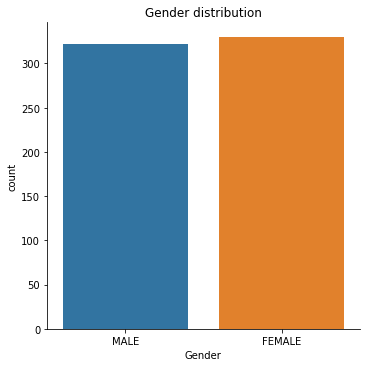

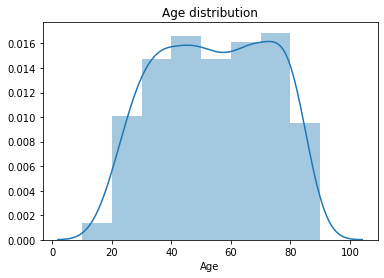

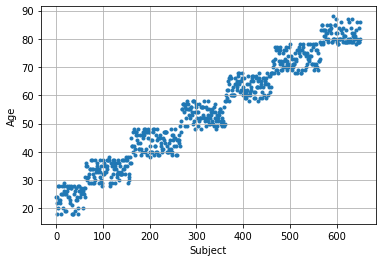

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

More or less evely distribbuted. May have some issues between 0 and 20


### Set up a simple medical image viewer and import SimpleITK

In [0]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


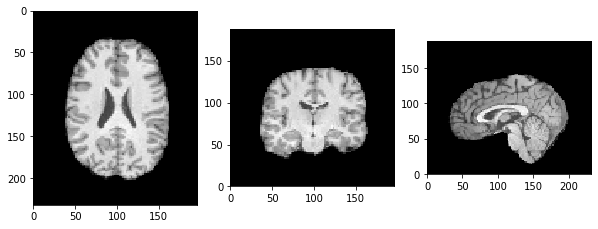

Brain mask (used in part A)


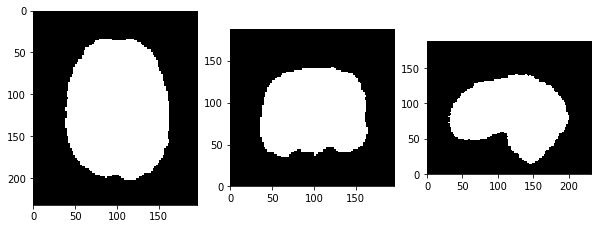

Spatially normalised grey matter maps (used in part B and C)


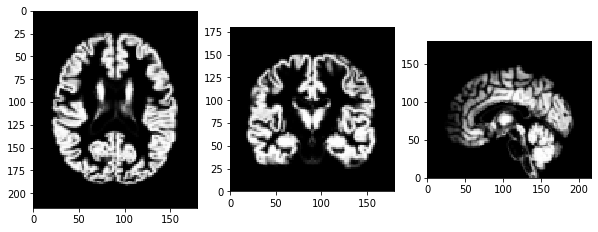

In [0]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [0]:
"""Normalizes an image to zero mean and unit variance."""
def zero_mean_unit_var(image, mask):

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0): # Resample image?
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [20]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla P100-PCIE-16GB


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [0]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training, validation and testing data

In [0]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

meta_data_reg_holdOuttest = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv') 
ids_seg_holdOuttest = list(meta_data_reg_holdOuttest['subject_id'])
files_seg_img_holdOuttest = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_holdOuttest]
files_seg_seg_holdOuttest = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_holdOuttest]
files_seg_msk_holdOuttest = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_holdOuttest]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [0]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

dataset_holdOuttest = ImageSegmentationDataset(files_seg_img_holdOuttest, files_seg_seg_holdOuttest, files_seg_msk_holdOuttest, img_spacing, img_size)
dataloader_holdOuttest = torch.utils.data.DataLoader(dataset_holdOuttest, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


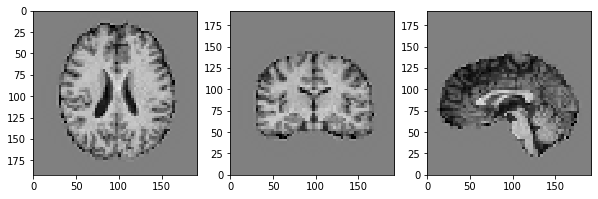

Segmentation


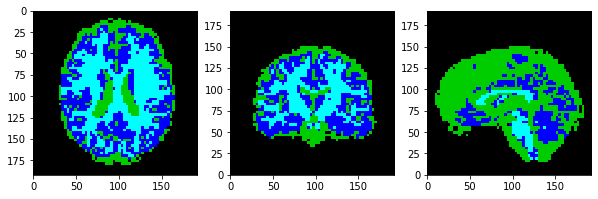

Mask


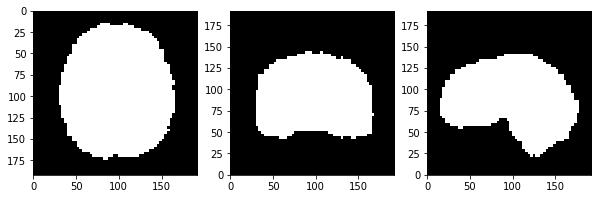

In [0]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py

In [0]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, residuals=True):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
        )
        self.residuals = residuals
        if self.residuals:
            if in_channels != out_channels:
                self.shortcut = nn.Sequential(
                    nn.Conv3d(in_channels, 
                            out_channels,
                            kernel_size=1,
                            padding = 0,
                            bias=False), 
                    nn.BatchNorm3d(out_channels)
                ) 
            else:
                self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.double_conv(x)
        if self.residuals:
            out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, residuals=True):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels, residuals=residuals)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, trilinear=True, residuals=True):
        super(Up, self).__init__()

        # if trilinear, use the normal convolutions to reduce the number of channels
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels, residuals=residuals)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)

        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, trilinear=True, residuals=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.trilinear = trilinear
        self.residuals = residuals

        self.inc = DoubleConv(n_channels, 64, residuals=residuals)
        self.down1 = Down(64, 128, residuals=residuals)
        self.down2 = Down(128, 256, residuals=residuals)
        self.down3 = Down(256, 512, residuals=residuals)
        self.down4 = Down(512, 512, residuals=residuals)
        self.up1 = Up(1024, 256, trilinear, residuals=residuals)
        self.up2 = Up(512, 128, trilinear, residuals=residuals)
        self.up3 = Up(256, 64, trilinear, residuals=residuals)
        self.up4 = Up(128, 64, trilinear, residuals=residuals)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

##### UNET WITH RESIDUALS


In [0]:
learning_rate = 0.01
batch_size = 16
num_epochs = 160

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = UNet(n_channels=1, n_classes=4, residuals=True).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.271404
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.152780


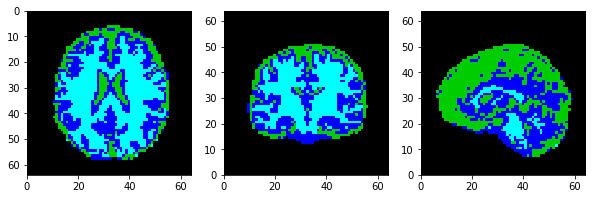

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.144918
+ TRAINING 	Epoch: 3 	Loss: 0.122080
+ TRAINING 	Epoch: 4 	Loss: 0.114482


In [0]:
loss_train_log = []
loss_val_log = []
epoch_val_log = []

best_loss_val = 100
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    train_loss = 0
    cpt = 0
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()/len(dataloader_train)

    loss_train_log.append(train_loss)
    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, train_loss))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts
        if loss_val <= best_loss_val:
            torch.save(model.state_dict(), os.path.join(model_dir, '/unet_res.pt'))
            torch.save(model.state_dict(), os.path.join(save_dir, '/unet_res.pt'))
            best_loss_val = loss_val

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')


print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

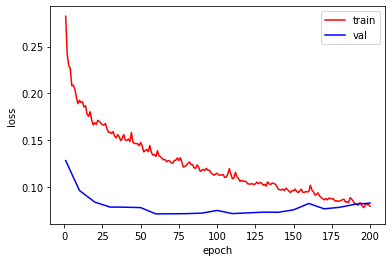

In [0]:
plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(model_dir+"/unet_nores")

##### UNET WITHOUT RESIDUALS

In [0]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = UNet(n_channels=1, n_classes=4, residuals=False).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.298981
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.241972


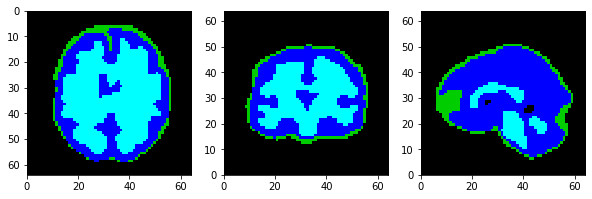

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.190707
+ TRAINING 	Epoch: 3 	Loss: 0.156775
+ TRAINING 	Epoch: 4 	Loss: 0.173201
+ TRAINING 	Epoch: 5 	Loss: 0.176929
+ TRAINING 	Epoch: 6 	Loss: 0.172398
+ TRAINING 	Epoch: 7 	Loss: 0.150816
+ TRAINING 	Epoch: 8 	Loss: 0.120046
+ TRAINING 	Epoch: 9 	Loss: 0.120279
+ TRAINING 	Epoch: 10 	Loss: 0.094092
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.108984


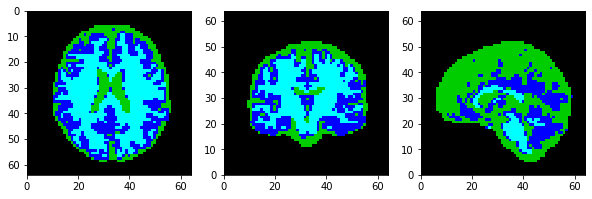

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.109335
+ TRAINING 	Epoch: 12 	Loss: 0.111291
+ TRAINING 	Epoch: 13 	Loss: 0.103112
+ TRAINING 	Epoch: 14 	Loss: 0.119939
+ TRAINING 	Epoch: 15 	Loss: 0.091810
+ TRAINING 	Epoch: 16 	Loss: 0.088125
+ TRAINING 	Epoch: 17 	Loss: 0.098573
+ TRAINING 	Epoch: 18 	Loss: 0.094342
+ TRAINING 	Epoch: 19 	Loss: 0.097182
+ TRAINING 	Epoch: 20 	Loss: 0.083562
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.096923


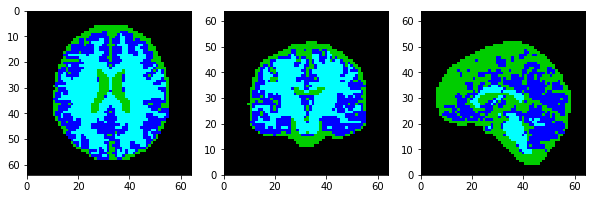

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.090639
+ TRAINING 	Epoch: 22 	Loss: 0.086099
+ TRAINING 	Epoch: 23 	Loss: 0.125389
+ TRAINING 	Epoch: 24 	Loss: 0.089671
+ TRAINING 	Epoch: 25 	Loss: 0.092299
+ TRAINING 	Epoch: 26 	Loss: 0.094346
+ TRAINING 	Epoch: 27 	Loss: 0.088361
+ TRAINING 	Epoch: 28 	Loss: 0.141129
+ TRAINING 	Epoch: 29 	Loss: 0.087822
+ TRAINING 	Epoch: 30 	Loss: 0.090153
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.089847


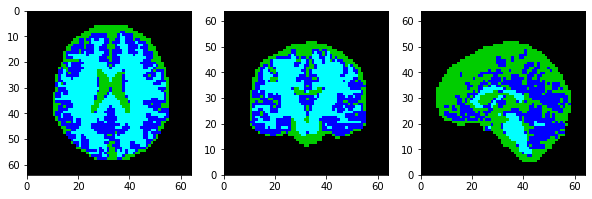

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.094353
+ TRAINING 	Epoch: 32 	Loss: 0.096567
+ TRAINING 	Epoch: 33 	Loss: 0.082150
+ TRAINING 	Epoch: 34 	Loss: 0.082875
+ TRAINING 	Epoch: 35 	Loss: 0.082054
+ TRAINING 	Epoch: 36 	Loss: 0.095465
+ TRAINING 	Epoch: 37 	Loss: 0.092282
+ TRAINING 	Epoch: 38 	Loss: 0.078265
+ TRAINING 	Epoch: 39 	Loss: 0.079932
+ TRAINING 	Epoch: 40 	Loss: 0.129688
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.093514


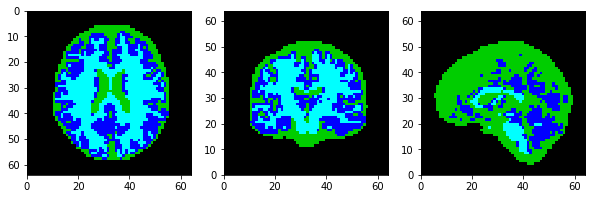

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.106532
+ TRAINING 	Epoch: 42 	Loss: 0.088670
+ TRAINING 	Epoch: 43 	Loss: 0.085811
+ TRAINING 	Epoch: 44 	Loss: 0.144492
+ TRAINING 	Epoch: 45 	Loss: 0.087267
+ TRAINING 	Epoch: 46 	Loss: 0.086433
+ TRAINING 	Epoch: 47 	Loss: 0.085167
+ TRAINING 	Epoch: 48 	Loss: 0.087780
+ TRAINING 	Epoch: 49 	Loss: 0.107961
+ TRAINING 	Epoch: 50 	Loss: 0.088559
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.091482


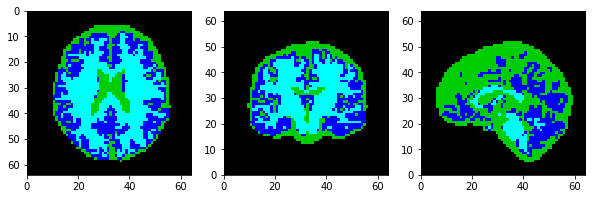

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.080281
+ TRAINING 	Epoch: 52 	Loss: 0.072391
+ TRAINING 	Epoch: 53 	Loss: 0.092327
+ TRAINING 	Epoch: 54 	Loss: 0.084790
+ TRAINING 	Epoch: 55 	Loss: 0.071290
+ TRAINING 	Epoch: 56 	Loss: 0.093232
+ TRAINING 	Epoch: 57 	Loss: 0.086001
+ TRAINING 	Epoch: 58 	Loss: 0.079389
+ TRAINING 	Epoch: 59 	Loss: 0.095751
+ TRAINING 	Epoch: 60 	Loss: 0.090877
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.083509


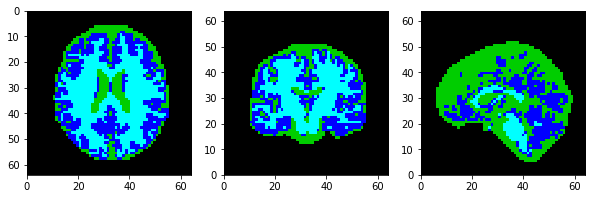

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.067270
+ TRAINING 	Epoch: 62 	Loss: 0.081178
+ TRAINING 	Epoch: 63 	Loss: 0.075704
+ TRAINING 	Epoch: 64 	Loss: 0.083573
+ TRAINING 	Epoch: 65 	Loss: 0.084297
+ TRAINING 	Epoch: 66 	Loss: 0.075016
+ TRAINING 	Epoch: 67 	Loss: 0.087328
+ TRAINING 	Epoch: 68 	Loss: 0.092622
+ TRAINING 	Epoch: 69 	Loss: 0.066013
+ TRAINING 	Epoch: 70 	Loss: 0.079250
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.082045


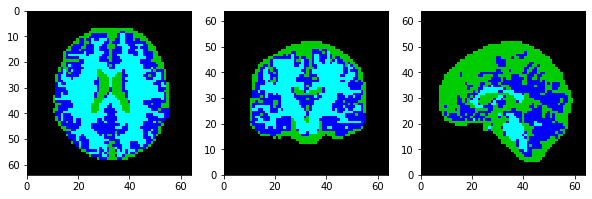

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.068549
+ TRAINING 	Epoch: 72 	Loss: 0.089838
+ TRAINING 	Epoch: 73 	Loss: 0.093797
+ TRAINING 	Epoch: 74 	Loss: 0.076064
+ TRAINING 	Epoch: 75 	Loss: 0.069243
+ TRAINING 	Epoch: 76 	Loss: 0.075918
+ TRAINING 	Epoch: 77 	Loss: 0.074987
+ TRAINING 	Epoch: 78 	Loss: 0.091170
+ TRAINING 	Epoch: 79 	Loss: 0.086995
+ TRAINING 	Epoch: 80 	Loss: 0.125138
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.080627


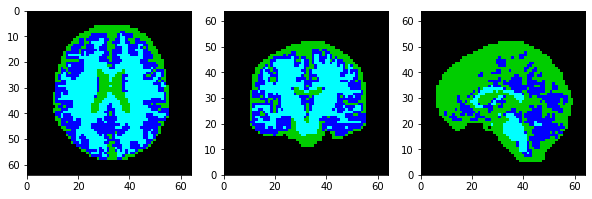

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.075991
+ TRAINING 	Epoch: 82 	Loss: 0.086869
+ TRAINING 	Epoch: 83 	Loss: 0.068919
+ TRAINING 	Epoch: 84 	Loss: 0.067195
+ TRAINING 	Epoch: 85 	Loss: 0.064955
+ TRAINING 	Epoch: 86 	Loss: 0.077486
+ TRAINING 	Epoch: 87 	Loss: 0.087636
+ TRAINING 	Epoch: 88 	Loss: 0.074180
+ TRAINING 	Epoch: 89 	Loss: 0.079170
+ TRAINING 	Epoch: 90 	Loss: 0.090775
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.081995


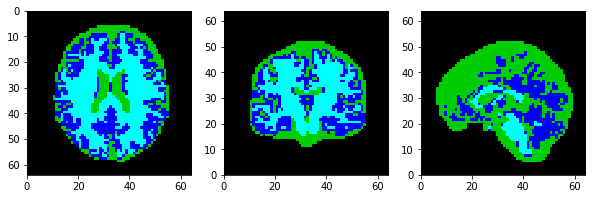

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.078499
+ TRAINING 	Epoch: 92 	Loss: 0.088971
+ TRAINING 	Epoch: 93 	Loss: 0.083364
+ TRAINING 	Epoch: 94 	Loss: 0.077156
+ TRAINING 	Epoch: 95 	Loss: 0.079560
+ TRAINING 	Epoch: 96 	Loss: 0.068439
+ TRAINING 	Epoch: 97 	Loss: 0.077222
+ TRAINING 	Epoch: 98 	Loss: 0.081085
+ TRAINING 	Epoch: 99 	Loss: 0.074369
+ TRAINING 	Epoch: 100 	Loss: 0.076142
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.076370


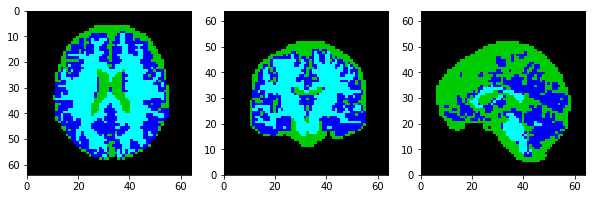

--------------------------------------------------
+ TRAINING 	Epoch: 101 	Loss: 0.109777
+ TRAINING 	Epoch: 102 	Loss: 0.105242
+ TRAINING 	Epoch: 103 	Loss: 0.071198
+ TRAINING 	Epoch: 104 	Loss: 0.063196
+ TRAINING 	Epoch: 105 	Loss: 0.072618
+ TRAINING 	Epoch: 106 	Loss: 0.082820
+ TRAINING 	Epoch: 107 	Loss: 0.112400
+ TRAINING 	Epoch: 108 	Loss: 0.096723
+ TRAINING 	Epoch: 109 	Loss: 0.065072
+ TRAINING 	Epoch: 110 	Loss: 0.079672
--------------------------------------------------
+ VALIDATE 	Epoch: 110 	Loss: 0.077967


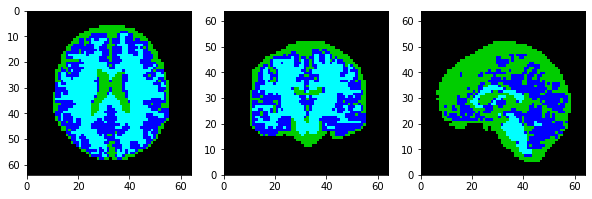

--------------------------------------------------
+ TRAINING 	Epoch: 111 	Loss: 0.066702
+ TRAINING 	Epoch: 112 	Loss: 0.057725
+ TRAINING 	Epoch: 113 	Loss: 0.081262
+ TRAINING 	Epoch: 114 	Loss: 0.067503
+ TRAINING 	Epoch: 115 	Loss: 0.062678
+ TRAINING 	Epoch: 116 	Loss: 0.062038
+ TRAINING 	Epoch: 117 	Loss: 0.076794
+ TRAINING 	Epoch: 118 	Loss: 0.096558
+ TRAINING 	Epoch: 119 	Loss: 0.070562
+ TRAINING 	Epoch: 120 	Loss: 0.064319
--------------------------------------------------
+ VALIDATE 	Epoch: 120 	Loss: 0.075150


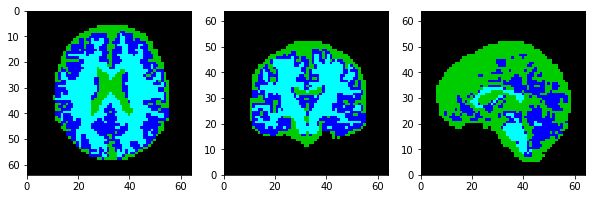

--------------------------------------------------
+ TRAINING 	Epoch: 121 	Loss: 0.069862
+ TRAINING 	Epoch: 122 	Loss: 0.077905
+ TRAINING 	Epoch: 123 	Loss: 0.070908
+ TRAINING 	Epoch: 124 	Loss: 0.062866
+ TRAINING 	Epoch: 125 	Loss: 0.070894
+ TRAINING 	Epoch: 126 	Loss: 0.058433
+ TRAINING 	Epoch: 127 	Loss: 0.064802
+ TRAINING 	Epoch: 128 	Loss: 0.061334
+ TRAINING 	Epoch: 129 	Loss: 0.090044
+ TRAINING 	Epoch: 130 	Loss: 0.071213
--------------------------------------------------
+ VALIDATE 	Epoch: 130 	Loss: 0.076729


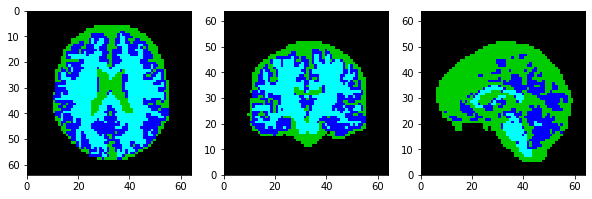

--------------------------------------------------
+ TRAINING 	Epoch: 131 	Loss: 0.070311
+ TRAINING 	Epoch: 132 	Loss: 0.060248
+ TRAINING 	Epoch: 133 	Loss: 0.067131
+ TRAINING 	Epoch: 134 	Loss: 0.075163
+ TRAINING 	Epoch: 135 	Loss: 0.057378
+ TRAINING 	Epoch: 136 	Loss: 0.047956
+ TRAINING 	Epoch: 137 	Loss: 0.058944
+ TRAINING 	Epoch: 138 	Loss: 0.063233
+ TRAINING 	Epoch: 139 	Loss: 0.056200
+ TRAINING 	Epoch: 140 	Loss: 0.059794
--------------------------------------------------
+ VALIDATE 	Epoch: 140 	Loss: 0.070231


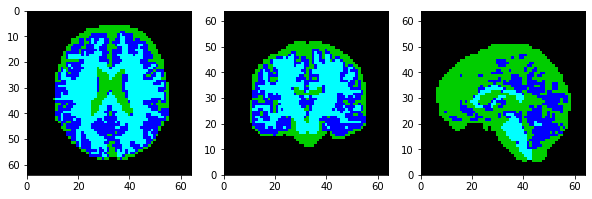

--------------------------------------------------
+ TRAINING 	Epoch: 141 	Loss: 0.057489
+ TRAINING 	Epoch: 142 	Loss: 0.067275
+ TRAINING 	Epoch: 143 	Loss: 0.054257
+ TRAINING 	Epoch: 144 	Loss: 0.066260
+ TRAINING 	Epoch: 145 	Loss: 0.062494
+ TRAINING 	Epoch: 146 	Loss: 0.054709
+ TRAINING 	Epoch: 147 	Loss: 0.049923
+ TRAINING 	Epoch: 148 	Loss: 0.056189
+ TRAINING 	Epoch: 149 	Loss: 0.059373
+ TRAINING 	Epoch: 150 	Loss: 0.052396
--------------------------------------------------
+ VALIDATE 	Epoch: 150 	Loss: 0.071513


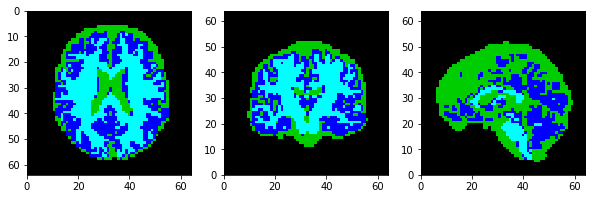

--------------------------------------------------
+ TRAINING 	Epoch: 151 	Loss: 0.061901
+ TRAINING 	Epoch: 152 	Loss: 0.055159
+ TRAINING 	Epoch: 153 	Loss: 0.050962
+ TRAINING 	Epoch: 154 	Loss: 0.067350
+ TRAINING 	Epoch: 155 	Loss: 0.047306
+ TRAINING 	Epoch: 156 	Loss: 0.050747
+ TRAINING 	Epoch: 157 	Loss: 0.064944
+ TRAINING 	Epoch: 158 	Loss: 0.062547
+ TRAINING 	Epoch: 159 	Loss: 0.058959
+ TRAINING 	Epoch: 160 	Loss: 0.060953
--------------------------------------------------
+ VALIDATE 	Epoch: 160 	Loss: 0.074595


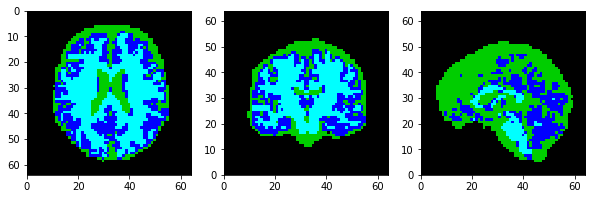

--------------------------------------------------
+ TRAINING 	Epoch: 161 	Loss: 0.059396
+ TRAINING 	Epoch: 162 	Loss: 0.061815
+ TRAINING 	Epoch: 163 	Loss: 0.056127
+ TRAINING 	Epoch: 164 	Loss: 0.060588
+ TRAINING 	Epoch: 165 	Loss: 0.062919
+ TRAINING 	Epoch: 166 	Loss: 0.052001
+ TRAINING 	Epoch: 167 	Loss: 0.055106
+ TRAINING 	Epoch: 168 	Loss: 0.051619
+ TRAINING 	Epoch: 169 	Loss: 0.075142
+ TRAINING 	Epoch: 170 	Loss: 0.046405
--------------------------------------------------
+ VALIDATE 	Epoch: 170 	Loss: 0.074083


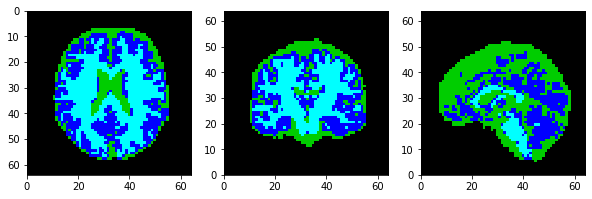

--------------------------------------------------
+ TRAINING 	Epoch: 171 	Loss: 0.049368
+ TRAINING 	Epoch: 172 	Loss: 0.060676
+ TRAINING 	Epoch: 173 	Loss: 0.048133
+ TRAINING 	Epoch: 174 	Loss: 0.059036
+ TRAINING 	Epoch: 175 	Loss: 0.053040
+ TRAINING 	Epoch: 176 	Loss: 0.052123
+ TRAINING 	Epoch: 177 	Loss: 0.066564
+ TRAINING 	Epoch: 178 	Loss: 0.053862
+ TRAINING 	Epoch: 179 	Loss: 0.053024
+ TRAINING 	Epoch: 180 	Loss: 0.056490
--------------------------------------------------
+ VALIDATE 	Epoch: 180 	Loss: 0.071650


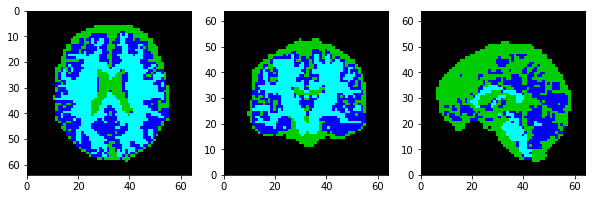

--------------------------------------------------
+ TRAINING 	Epoch: 181 	Loss: 0.058438
+ TRAINING 	Epoch: 182 	Loss: 0.048112
+ TRAINING 	Epoch: 183 	Loss: 0.044572
+ TRAINING 	Epoch: 184 	Loss: 0.057763
+ TRAINING 	Epoch: 185 	Loss: 0.067436
+ TRAINING 	Epoch: 186 	Loss: 0.051322
+ TRAINING 	Epoch: 187 	Loss: 0.050412
+ TRAINING 	Epoch: 188 	Loss: 0.050549
+ TRAINING 	Epoch: 189 	Loss: 0.055916
+ TRAINING 	Epoch: 190 	Loss: 0.061886
--------------------------------------------------
+ VALIDATE 	Epoch: 190 	Loss: 0.071926


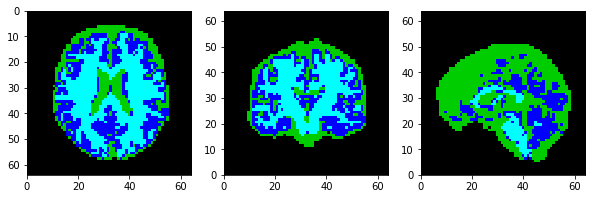

--------------------------------------------------
+ TRAINING 	Epoch: 191 	Loss: 0.054976
+ TRAINING 	Epoch: 192 	Loss: 0.043277
+ TRAINING 	Epoch: 193 	Loss: 0.043991
+ TRAINING 	Epoch: 194 	Loss: 0.064522
+ TRAINING 	Epoch: 195 	Loss: 0.054142
+ TRAINING 	Epoch: 196 	Loss: 0.051247
+ TRAINING 	Epoch: 197 	Loss: 0.054318
+ TRAINING 	Epoch: 198 	Loss: 0.045868
+ TRAINING 	Epoch: 199 	Loss: 0.051389
+ TRAINING 	Epoch: 200 	Loss: 0.047948
--------------------------------------------------
+ VALIDATE 	Epoch: 200 	Loss: 0.077220


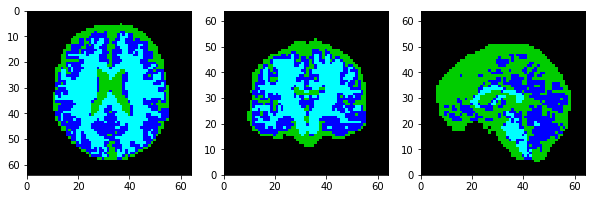

--------------------------------------------------

Finished TRAINING.


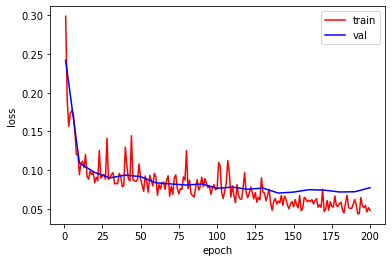

In [0]:
learning_rate = 0.009
batch_size = 16
num_epochs = 200
loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, '/model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
torch.save(model.state_dict(), os.path.join(save_dir, '/model.pt'))
# torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))


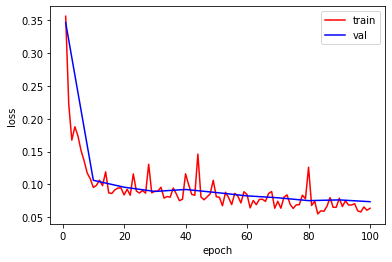

In [0]:
plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(model_dir+"/unet_nores")

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [0]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:22<00:00,  6.03it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


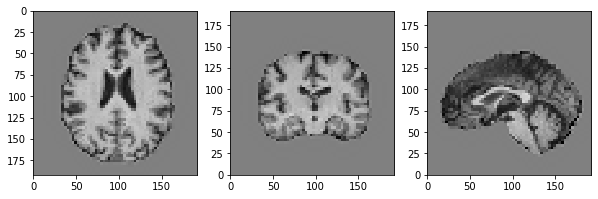

Segmentation


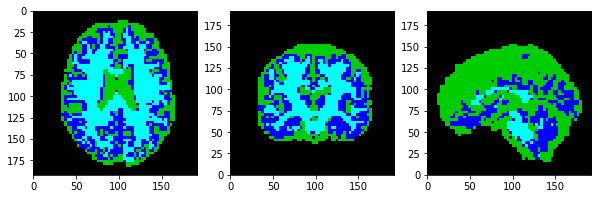

Mask


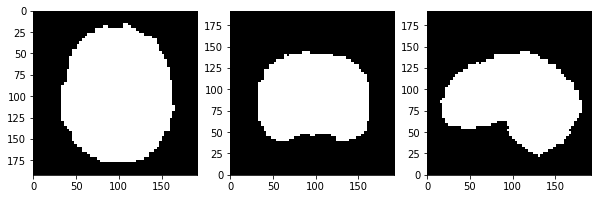

In [0]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

##### Helpers

In [0]:
def dice_score(pred, targs):
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def dice_score_class(seg, pred):
    mseg = make_lbls_onehot(seg.view(-1),4)
    mpred = make_lbls_onehot(prd.view(-1),4)
    dc0 = dice_score(mseg[:,0], mpred[:,0])
    dc1 = dice_score(mseg[:,1], mpred[:,1])
    dc2 = dice_score(mseg[:,2], mpred[:,2])
    dc3 = dice_score(mseg[:,3], mpred[:,3])
    
    return dc0, dc1, dc2, dc3

def make_lbls_onehot(lbls, num_classes):
    # lbls: np.array of shape [N]
    lbls_onehot = torch.zeros(size=(lbls.shape[0], num_classes ) )
    lbls_onehot[ torch.arange(lbls_onehot.shape[0]), lbls ] = 1
    return lbls_onehot

##### On validation set

START TESTING...
+ TESTING
+	Loss: 0.078417
+	Dice score class 0: 0.991853
+	Dice score class 1: 0.833202
+	Dice score class 2: 0.905372
+	Dice score class 3: 0.930608


Reference segmentation


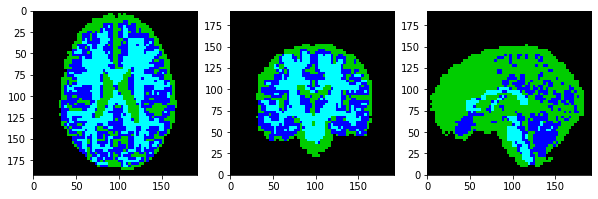

Predicted segmentation


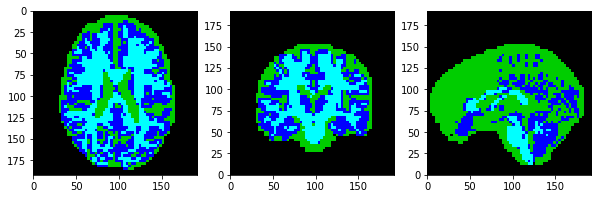


Finished TESTING.


In [0]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = UNet(n_channels=1, n_classes=4, residuals=True)
model.load_state_dict(torch.load(os.path.join(save_dir, 'models/unet_res.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
dice_class_0 = 0
dice_class_1 = 0
dice_class_2 = 0
dice_class_3 = 0

dice0= []
dice1= []
dice2= []
dice3= []

sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0).size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()

        sum_pts += seg_flat.size(2)        
        prd = torch.argmax(prd, dim=1)
        
        dc0, dc1, dc2, dc3 = dice_score_class(seg, prd)
        dice_class_0 += dc0
        dice_class_1 += dc1
        dice_class_2 += dc2
        dice_class_3 += dc3

        dice0.append(dc0)
        dice1.append(dc1)
        dice2.append(dc2)
        dice3.append(dc3)
        

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
dice_class_0 /= idx_test
dice_class_1 /= idx_test
dice_class_2 /= idx_test
dice_class_3 /= idx_test


print(f'+ TESTING')
print(f'+\tLoss: {loss_test:.6f}')
print(f'+\tDice score class 0: {dice_class_0:.6f}')
print(f'+\tDice score class 1: {dice_class_1:.6f}')
print(f'+\tDice score class 2: {dice_class_2:.6f}')
print(f'+\tDice score class 3: {dice_class_3:.6f}')


# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

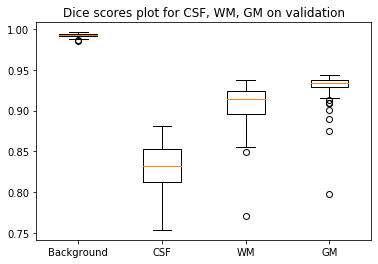

In [0]:
data=[dice0,dice1,dice2,dice3]

fig1, ax1 = plt.subplots()
ax1.set_title('Dice scores plot for CSF, WM, GM on validation')
ax1.boxplot(data)
ax1.set_xticklabels(["Background", "CSF", "WM", "GM"])
plt.savefig("val_dice")
plt.show()

##### On hold out test set

START TESTING...
+ TESTING
+	Loss: 0.073346
+	Dice score class 0: 0.992277
+	Dice score class 1: 0.831753
+	Dice score class 2: 0.906867
+	Dice score class 3: 0.929926


Reference segmentation


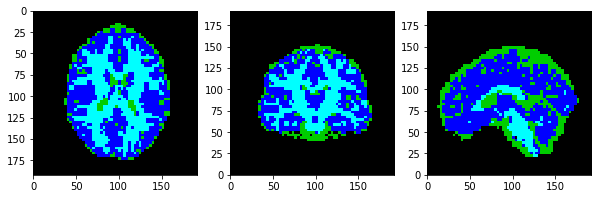

Predicted segmentation


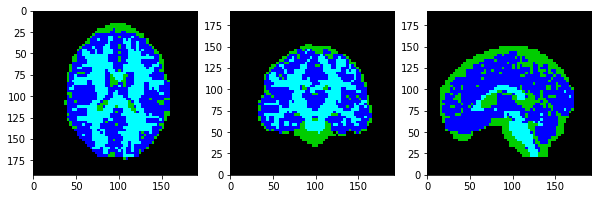


Finished TESTING.


In [0]:
pred_dir = os.path.join(out_dir, 'pred_test')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = UNet(n_channels=1, n_classes=4, residuals=True)
model.load_state_dict(torch.load(os.path.join(save_dir, 'models/unet_res.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
dice_class_0 = 0
dice_class_1 = 0
dice_class_2 = 0
dice_class_3 = 0

dice0= []
dice1= []
dice2= []
dice3= []

sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_holdOuttest:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0).size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()

        sum_pts += seg_flat.size(2)        
        prd = torch.argmax(prd, dim=1)
        
        dc0, dc1, dc2, dc3 = dice_score_class(seg, prd)
        dice_class_0 += dc0
        dice_class_1 += dc1
        dice_class_2 += dc2
        dice_class_3 += dc3

        dice0.append(dc0)
        dice1.append(dc1)
        dice2.append(dc2)
        dice3.append(dc3)
        

        sample = dataset_holdOuttest.get_sample(idx_test)
        name = dataset_holdOuttest.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
dice_class_0 /= idx_test
dice_class_1 /= idx_test
dice_class_2 /= idx_test
dice_class_3 /= idx_test


print(f'+ TESTING')
print(f'+\tLoss: {loss_test:.6f}')
print(f'+\tDice score class 0: {dice_class_0:.6f}')
print(f'+\tDice score class 1: {dice_class_1:.6f}')
print(f'+\tDice score class 2: {dice_class_2:.6f}')
print(f'+\tDice score class 3: {dice_class_3:.6f}')


# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

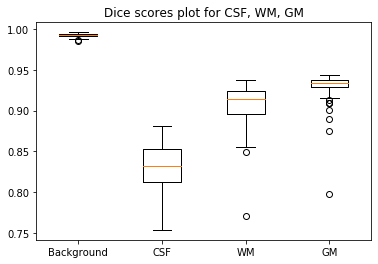

In [0]:
data=[dice0,dice1,dice2,dice3]

fig1, ax1 = plt.subplots()
ax1.set_title('Dice scores plot for CSF, WM, GM')
ax1.boxplot(data)
ax1.set_xticklabels(["Background", "CSF", "WM", "GM"])
plt.savefig("test_dice")
plt.show()

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

#### Helpers

In [0]:
## CALCULATE ABSOLUTE TISSUE VOLUMES
def make_lbls_onehot(lbls, num_classes):
  # lbls: np.array of shape [N]
  lbls_onehot = torch.zeros(size=(lbls.shape[0], num_classes ) )
  lbls_onehot[ torch.arange(lbls_onehot.shape[0]), lbls ] = 1
  return lbls_onehot

# Absolute volume
def abs_volume(data):
  pre=make_lbls_onehot(data.view(-1),4)
  vol=pre.sum(dim=0)
  GM=vol[2].item()
  WM=vol[3].item()
  CSF=vol[1].item()
  return  CSF,GM,WM

# Relative volume
def rel_volume(data):
  pre=make_lbls_onehot(data.view(-1),4)
  vol=pre.sum(dim=0)
  total=pre.shape[0]-vol[0].item()
  GM=vol[2].item()/total
  WM=vol[3].item()/total
  CSF=vol[1].item()/total
  return CSF,GM,WM

#### Absolute Volumes on validation set

In [0]:
import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'
seg_dir_test = './output/pred_test/'
# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
# seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]
files_reg_seg_holdOuttest = [seg_dir_test + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_holdOuttest]
# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))


for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):

    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        res_seg=resample_image(seg,img_spacing, img_size,is_label=True)
        seg_arr=torch.from_numpy(sitk.GetArrayFromImage(res_seg)).unsqueeze(0)
        vols[0,idx],vols[1,idx],vols[2,idx]=abs_volume(seg_arr.long())
        ########################################
        # ADD YOUR CODE HERE
        ########################################

Calculating Features: 100%|██████████| 500/500 [00:04<00:00, 124.64it/s]


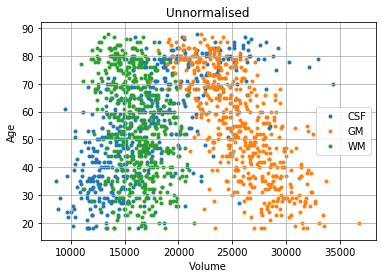

In [0]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

#### Relative Volumes on validation set

In [0]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):

    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        res_seg=resample_image(seg,img_spacing, img_size,is_label=True)
        seg_arr=torch.from_numpy(sitk.GetArrayFromImage(res_seg)).unsqueeze(0)
        vols_normalised[0,idx],vols_normalised[1,idx],vols_normalised[2,idx]=rel_volume(seg_arr.long())

Calculating Features: 100%|██████████| 500/500 [00:04<00:00, 124.27it/s]


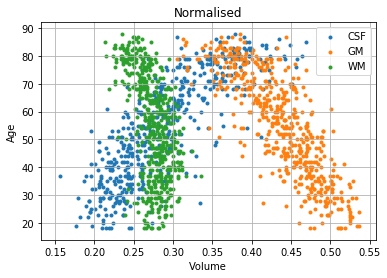

In [0]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

#### Relative Volumes on test set

In [0]:
## CALCULATE RELATIVE TISSUE VOLUMES FOR TEST DATASET

vols_normalised_holdOuttest= np.zeros((3,len(files_reg_seg_holdOuttest)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_holdOuttest)), desc='Calculating Features')):

    seg_filename = files_reg_seg_holdOuttest[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        res_seg=resample_image(seg,img_spacing, img_size,is_label=True)
        seg_arr=torch.from_numpy(sitk.GetArrayFromImage(res_seg)).unsqueeze(0)
        vols_normalised_holdOuttest[0,idx],vols_normalised_holdOuttest[1,idx],vols_normalised_holdOuttest[2,idx]=rel_volume(seg_arr.long())

Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 125.61it/s]


Plot normalised features versus age.

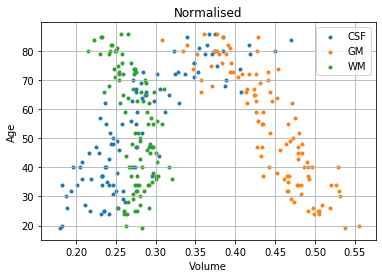

In [0]:
plt.scatter(vols_normalised_holdOuttest[0,:],meta_data_reg_holdOuttest['age'], marker='.')
plt.scatter(vols_normalised_holdOuttest[1,:],meta_data_reg_holdOuttest['age'], marker='.')
plt.scatter(vols_normalised_holdOuttest[2,:],meta_data_reg_holdOuttest['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

#### Final data for regression

In [0]:
X_train = vols_normalised.T
y_train = meta_data_reg_train['age'].values.reshape(-1,1)

X_test = vols_normalised_holdOuttest.T
y_test = meta_data_reg_holdOuttest['age'].values.reshape(-1,1)

print(f"X train\t : {X_train.shape}")
print(f"Y train\t : {y_train.shape}")

print(f"X test\t : {X_test.shape}")
print(f"Y test\t : {y_test.shape}")


X train	 : (500, 3)
Y train	 : (500, 1)
X test	 : (100, 3)
Y test	 : (100, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

#### Preparing data

In [0]:
import os
from sklearn.metrics import mean_absolute_error,r2_score

In [0]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [0]:
#Regroups WM and GM data as they tend to evolve in the same direction
X_CSF=np.reshape(X_train[:,0],(-1,1))
X_composed=np.reshape(np.sum(X_train[:,1:],axis=1),(-1,1))
X_modfied=np.hstack((X_CSF,X_composed))

X_CSF_test=np.reshape(X_test[:,0],(-1,1))
X_composed_test=np.reshape(np.sum(X_test[:,1:],axis=1),(-1,1))
X_modfied_test=np.hstack((X_CSF_test,X_composed_test))


In [0]:
# Build a list of files from first validation set
y_1 = meta_val_1['age'].values.reshape(-1,1)
X_val_1 = X_modfied[meta_val_1.index]

# Build a list of files from second validation set
y_2 = meta_val_2['age'].values.reshape(-1,1)
X_val_2 = X_modfied[meta_val_2.index]

# Folds for cross val
fold = [(X_val_1, y_1, X_val_2, y_2), ( X_val_2, y_2, X_val_1, y_1)]

# Test set

#### Regression with SVMs

In [0]:
#SVM for Regression
scores= {'MAE' : [], 'R2' : []}


for x, y, x_val, y_val in fold:
    svr_lin = svm.SVR(kernel='linear', C=100, gamma='auto')
    svr_lin.fit(x , y.ravel())
    y_pred =svr_lin.predict(x_val)
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

print("\n\n--- TRAINING ON ALL DATASET ---\n\n")
svr_lin = svm.SVR(kernel='linear', C=100, gamma='auto')
svr_lin.fit(X_modfied , y_train.ravel())

print("--- SCORES ON TEST SET ---\n")
y_pred = svr_lin.predict(X_modfied_test)
mae = mean_absolute_error(y_pred, y_test.ravel())
r2 = r2_score(y_test.ravel(), y_pred)

print(f"MAE test set : {mae}")
print(f"R2 test set : {r2}")

=== RESULTS CROSS VAL ===
MAE cross validation : [8.812407460976274, 8.698249158464575]
R2 cross validation : [0.6461683214692435, 0.6448259299533945]

=== MEANS ===
MAE mean cross validation : 8.755328309720426
R2 mean cross validation : 0.645497125711319


--- TRAINING ON ALL DATASET ---


--- SCORES ON TEST SET ---

MAE test set : 8.94611691897274
R2 test set : 0.6976587479318952


In [0]:
#SVM for Regression
scores= {'MAE' : [], 'R2' : []}


for x, y, x_val, y_val in fold:
    svr_poly = svm.SVR(kernel='poly', C=125, gamma='auto', degree=12, epsilon=2,coef0=1.1)
    svr_poly.fit(x , y.ravel())
    y_pred =svr_poly.predict(x_val)
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")


print("\n\n--- TRAINING ON ALL DATASET ---\n\n")
svr_poly = svm.SVR(kernel='poly', C=125, gamma='auto', degree=12, epsilon=2,coef0=1.1)
svr_poly.fit(X_modfied , y_train.ravel())

print("--- SCORES ON TEST SET ---\n")
y_pred = svr_poly.predict(X_modfied_test)
mae = mean_absolute_error(y_pred, y_test.ravel())
r2 = r2_score(y_test.ravel(), y_pred)

print(f"MAE test set : {mae}")
print(f"R2 test set : {r2}")

=== RESULTS CROSS VAL ===
MAE cross validation : [8.163415927163417, 7.999223741474]
R2 cross validation : [0.6779084037389429, 0.66870309150122]

=== MEANS ===
MAE mean cross validation : 8.081319834318709
R2 mean cross validation : 0.6733057476200814


--- TRAINING ON ALL DATASET ---


--- SCORES ON TEST SET ---

MAE test set : 8.07084094152069
R2 test set : 0.7365307824029952


#### Regression with Linear Regression

In [0]:
# Linear Regression
scores= {'MAE' : [], 'R2' : []}


for x, y, x_val, y_val in fold:
    lm = LinearRegression()
    lm.fit(x , y.ravel())
    y_pred =lm.predict(x_val)
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

print("\n\n--- TRAINING ON ALL DATASET ---\n\n")
lm = LinearRegression()
lm.fit(X_modfied , y_train.ravel())

print("--- SCORES ON TEST SET ---\n")
y_pred = lm.predict(X_modfied_test)
mae = mean_absolute_error(y_pred, y_test.ravel())
r2 = r2_score(y_test.ravel(), y_pred)

print(f"MAE test set : {mae}")
print(f"R2 test set : {r2}")

=== RESULTS CROSS VAL ===
MAE cross validation : [8.8245625, 8.70625]
R2 cross validation : [0.649838406684871, 0.6417979792648323]

=== MEANS ===
MAE mean cross validation : 8.765406250000002
R2 mean cross validation : 0.6458181929748517


--- TRAINING ON ALL DATASET ---


--- SCORES ON TEST SET ---

MAE test set : 9.01763671875
R2 test set : 0.6971957475483932


#### Regression with xgboost

In [0]:
# xgboost regressor
scores= {'MAE' : [], 'R2' : []}

for x, y, x_val, y_val in fold:
    eval_set = [(x_val, y_val)]
    xgbr = XGBRegressor(learning_rate=0.0008, n_estimators=10000, max_depth=2 , objective='reg:squarederror')
    xgbr.fit(x , y.ravel(), early_stopping_rounds=500, eval_metric="mae", eval_set=eval_set, verbose=False)
    y_pred =xgbr.predict(x_val)
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))
    print(f"best iteration : {xgbr.best_iteration}")
    print(f"best ntree_limit : {xgbr.best_ntree_limit}")
    print("####")

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

print("\n\n--- TRAINING ON ALL DATASET ---\n\n")
xgbr = XGBRegressor(learning_rate=0.0008, n_estimators=8463, max_depth=2 , objective='reg:squarederror')
xgbr.fit(X_modfied , y_train.ravel())

print("--- SCORES ON TEST SET ---\n")
y_pred = xgbr.predict(X_modfied_test)
mae = mean_absolute_error(y_pred, y_test.ravel())
r2 = r2_score(y_test.ravel(), y_pred)

print(f"MAE test set : {mae}")
print(f"R2 test set : {r2}")

best iteration : 6627
best ntree_limit : 6628
####
best iteration : 6675
best ntree_limit : 6676
####
=== RESULTS CROSS VAL ===
MAE cross validation : [8.55916293334961, 8.300351570129395]
R2 cross validation : [0.6620795149852832, 0.653471888040021]

=== MEANS ===
MAE mean cross validation : 8.429757251739503
R2 mean cross validation : 0.6577757015126521


--- TRAINING ON ALL DATASET ---


--- SCORES ON TEST SET ---

MAE test set : 8.208900470733642
R2 test set : 0.7186985399242619


#### Regression with Neural Network


In [0]:
########################################
# ADD YOUR CODE HERE
########################################
import torch
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(inputSize, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 40),
            nn.ReLU(inplace=True),
            nn.Linear(40, 80),
            nn.ReLU(inplace=True),
            nn.Linear(80, 40),
            nn.ReLU(inplace=True),
            nn.Linear(40, outputSize)
        )
        

    def forward(self, x):
        return self.main(x)

In [0]:
class LinDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, X, y):
        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(y)), desc='Loading Data')):
            sample = {'features': torch.Tensor(X[idx,:]), 'y': torch.Tensor(y[idx])}
            self.samples.append(sample)



    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]
        return sample

In [0]:
num_epochs = 5000
learning_rate = 0.001
batch_size = 64

modelLin_1 = linearRegression(inputSize=2, outputSize=1).to(device)
modelLin_1.train()
optimizer_1 = torch.optim.Adam(modelLin_1.parameters(), lr=learning_rate)

modelLin_2 = linearRegression(inputSize=2, outputSize=1).to(device)
modelLin_2.train()
optimizer_2 = torch.optim.Adam(modelLin_2.parameters(), lr=learning_rate)

In [0]:
ds1 = LinDataset(X_val_1, y_1)
ds2 = LinDataset(X_val_2, y_2)

dataloader_train_1 = torch.utils.data.DataLoader(ds1, batch_size=batch_size, shuffle=True)
dataloader_val_1 = torch.utils.data.DataLoader(ds2, batch_size=batch_size, shuffle=True)

dataloader_train_2 = torch.utils.data.DataLoader(ds2, batch_size=batch_size, shuffle=True)
dataloader_val_2 = torch.utils.data.DataLoader(ds1, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 250/250 [00:00<00:00, 25120.41it/s]


In [0]:
def train_lin(model, dataloader_t, dataloader_v, optimizer):
    loss_train_log = []
    loss_val_log = []
    epoch_val_log = []
    val_interval = 300
    print_every = 500
    best_val = 1000
    best_weights = 0


    print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):

        # Training
        for batch_idx, batch_samples in enumerate(dataloader_t):
            features, age = batch_samples['features'].to(device), batch_samples['y'].to(device)
            optimizer.zero_grad()
            prd = model(features)
            prd_flat = prd.view(-1)
            age_flat = age.view(-1)
            loss = nn.L1Loss()(prd_flat, age_flat)
            loss.backward()
            # print(loss.grad)
            optimizer.step()

        loss_train_log.append(loss.item())
        if epoch % print_every == 0:
            print(f"Epoch {epoch}")
        
        # Validation
        if dataloader_v is not None:
            if epoch == 1 or epoch % val_interval == 0:
                loss_val = 0
                sum_pts = 0
                with torch.no_grad():
                    for data_sample in dataloader_v:
                        features, age = data_sample['features'].to(device), data_sample['y'].to(device)
                        prd = model(features)
                        prd_flat = prd.view(-1)
                        age_flat = age.view(-1)
                        loss_val += F.l1_loss(prd_flat, age_flat).item()
                        sum_pts += 1

                loss_val /= sum_pts
                if loss_val < best_val:
                    best_weights = model.state_dict()

                loss_val_log.append(loss_val)
                epoch_val_log.append(epoch)

                print('--------------------------------------------------')
                print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
                print('--------------------------------------------------')
    if dataloader_v is not None:
        model.load_state_dict(best_weights)

    print('\nFinished TRAINING.')
    return model, loss_train_log, loss_val_log, epoch_val_log


In [0]:
model_lin1, loss_train_log_1, loss_val_log_1, epoch_val_log_1 = train_lin(modelLin_1, dataloader_train_1, dataloader_val_1, optimizer_1)

START TRAINING...
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 54.239408
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 300 	Loss: 8.937082
--------------------------------------------------
Epoch 500
--------------------------------------------------
+ VALIDATE 	Epoch: 600 	Loss: 8.656729
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 900 	Loss: 8.547309
--------------------------------------------------
Epoch 1000
--------------------------------------------------
+ VALIDATE 	Epoch: 1200 	Loss: 8.507938
--------------------------------------------------
Epoch 1500
--------------------------------------------------
+ VALIDATE 	Epoch: 1500 	Loss: 8.497094
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 1800 	Loss: 8.424839
------------

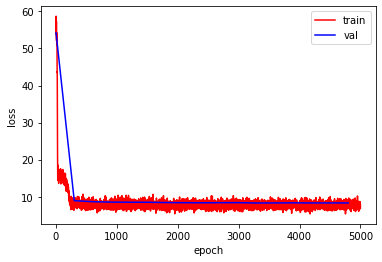

In [0]:
plt.plot(range(1, num_epochs + 1), loss_train_log_1, c='r', label='train')
plt.plot(epoch_val_log_1, loss_val_log_1, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
model_lin2, loss_train_log_2, loss_val_log_2, epoch_val_log_2 = train_lin(modelLin_2, dataloader_train_2, dataloader_val_2, optimizer_2)

START TRAINING...
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 55.077209
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 300 	Loss: 8.395065
--------------------------------------------------
Epoch 500
--------------------------------------------------
+ VALIDATE 	Epoch: 600 	Loss: 8.468257
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 900 	Loss: 8.369832
--------------------------------------------------
Epoch 1000
--------------------------------------------------
+ VALIDATE 	Epoch: 1200 	Loss: 8.245744
--------------------------------------------------
Epoch 1500
--------------------------------------------------
+ VALIDATE 	Epoch: 1500 	Loss: 8.025515
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 1800 	Loss: 7.998413
------------

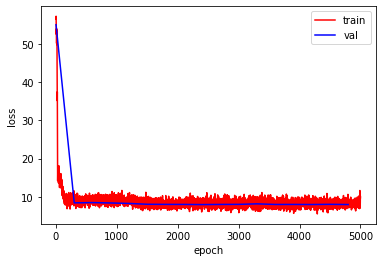

In [0]:
plt.plot(range(1, num_epochs + 1), loss_train_log_2, c='r', label='train')
plt.plot(epoch_val_log_2, loss_val_log_2, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
scores= {'MAE' : [], 'R2' : []}

# First Fold
with torch.no_grad():
    prd = modelLin_1(torch.Tensor(X_val_2).to(device))
    y_pred = prd.view(-1).cpu().numpy()
    y_val = y_2
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

# Second Fold
with torch.no_grad():
    prd = modelLin_2(torch.Tensor(X_val_1).to(device))
    y_pred = prd.view(-1).cpu().numpy()
    y_val = y_1
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

=== RESULTS CROSS VAL ===
MAE cross validation : [8.319704330444337, 7.972529731750488]
R2 cross validation : [0.6527013889116196, 0.6801838528971114]

=== MEANS ===
MAE mean cross validation : 8.146117031097413
R2 mean cross validation : 0.6664426209043655


In [0]:
# Training on all dataset
modelLin = linearRegression(inputSize=2, outputSize=1).to(device)
modelLin.train()
optimizer = torch.optim.Adam(modelLin.parameters(), lr=learning_rate)
ds = LinDataset(X_modfied, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=
batch_size, shuffle=True)

model_lin, loss_train_log, loss_val_log, epoch_val_log = train_lin(modelLin, dataloader_train, None, optimizer)

Loading Data: 100%|██████████| 500/500 [00:00<00:00, 57431.04it/s]


START TRAINING...
Epoch 500
Epoch 1000
Epoch 1500
Epoch 2000
Epoch 2500
Epoch 3000
Epoch 3500
Epoch 4000
Epoch 4500
Epoch 5000

Finished TRAINING.


In [0]:
with torch.no_grad():
    prd = model_lin(torch.Tensor(X_modfied_test).to(device))
    y_pred = prd.view(-1).cpu().numpy()
    y_val = y_test

    mae = mean_absolute_error(y_pred, y_test.ravel())
    r2 = r2_score(y_test.ravel(), y_pred)

    print(f"MAE test set : {mae}")
    print(f"R2 test set : {r2}")


MAE test set : 7.919131774902343
R2 test set : 0.7455046832338359


#### Scatter plot

--- SCORES ON TEST SET ---



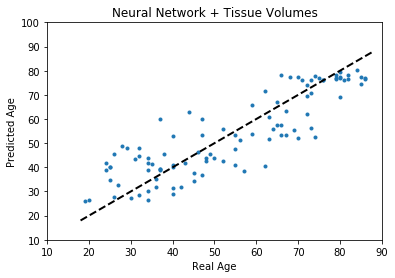

In [0]:
print("--- SCORES ON TEST SET ---\n")
with torch.no_grad():
    prd = model_lin(torch.Tensor(X_modfied_test).to(device))
    y_pred = prd.view(-1).cpu().numpy()


    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, marker='.')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')
    ax.set_xlim(10,90)
    ax.set_ylim(10,100)
    ax.set_title("Neural Network + Tissue Volumes")
    plt.savefig('cc.png')
    plt.show()

Error calculation and plotting

link for Unet without res connections
https://drive.google.com/open?id=1-DB8GhD09BYi2OTugscUEgWLohag0RLX

link for lin model 
https://drive.google.com/open?id=1-DrxeRk1T4LHyYhGSy48bIH49z6gjuqf

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

In [0]:
########################################
# ADD YOUR CODE HERE
########################################
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np 
import SimpleITK as sitk
import matplotlib.pyplot as plt

# data directory
data_dir = 'data/brain_age/'
save_dir = '/content/drive/My Drive/Imperial/MLI/CW/mli-coursework'

In [0]:
# Getting dataset of GM
meta_data_reg_holdOuttest = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv') 
ids_seg_holdOuttest = list(meta_data_reg_holdOuttest['subject_id'])

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_gm_train = list(meta_data_reg_train['subject_id'])
files_gm_train = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_gm_train]
files_gm_test = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_seg_holdOuttest]

#### Smoothing images

In [0]:
def discrete_Gaussian(sig, files, name):
    n_dir = data_dir+f'{name}_sig_{sig}/'

    try:
        os.mkdir(n_dir)
    except FileExistsError:
        pass
    
    for k in tqdm(range(len(files))):
        img = sitk.DiscreteGaussian(
            sitk.Cast(sitk.ReadImage(files[k]), sitk.sitkFloat32), 
            sig)
        sitk.WriteImage(img, n_dir+ files[k].replace(data_dir + 'greymatter/', ""))
        
def gradient_Anisotropic_Diffusion(files, name):
    n_dir = data_dir+f'{name}/'

    try:
        os.mkdir(n_dir)
    except FileExistsError:
        pass

    for k in tqdm(range(len(files))):
        img = sitk.GradientAnisotropicDiffusion(
            sitk.Cast(sitk.ReadImage(files[k]), sitk.sitkFloat32))
        sitk.WriteImage(img, n_dir+ files[k].replace(data_dir + 'greymatter/', ""))
        

def downsample(img, factor=2):
    smoothed = sitk.DiscreteGaussian(img, (.5 * factor) ** 2)   
    return smoothed[::factor, ::factor, ::factor]

def downsample_ds(files, name, factor=2):
    n_dir = data_dir+f'{name}_f_{factor}/'

    try:
        os.mkdir(n_dir)
    except FileExistsError:
        pass
    
    for k in tqdm(range(len(files))):
        img = downsample(sitk.Cast(sitk.ReadImage(files[k]), sitk.sitkFloat32))     
        sitk.WriteImage(img, n_dir+ files[k].replace(data_dir + 'greymatter/', ""))


In [0]:
discrete_Gaussian(1, files_gm_train, "train_dg")
gradient_Anisotropic_Diffusion(files_gm_train, "train_grad")
downsample_ds(files_gm_train, "train_downsample")

100%|██████████| 500/500 [00:40<00:00, 12.47it/s]


In [0]:
discrete_Gaussian(1, files_gm_test, "test_dg")
gradient_Anisotropic_Diffusion(files_gm_test, "test_grad")
downsample_ds(files_gm_test, "test_downsample")

100%|██████████| 100/100 [00:08<00:00, 12.37it/s]


#### Downsampling (in case needed for memory issues)

In [0]:
train_downsampled_files = [data_dir + 'train_downsample_f2'+'/wc1sub-' + f + '_T1w.nii.gz' for f in ids_gm_train]
train_grad_gm_files = [data_dir + 'train_grad'+'/wc1sub-' + f + '_T1w.nii.gz' for f in ids_gm_train]
train_dg_gm_files = [data_dir + 'train_dg_sig_1'+'/wc1sub-' + f + '_T1w.nii.gz' for f in ids_gm_train]

test_downsampled_files = [data_dir + 'test_downsample_f2'+'/wc1sub-' + f + '_T1w.nii.gz' for f in ids_seg_holdOuttest]
test_grad_gm_files = [data_dir + 'test_grad'+'/wc1sub-' + f + '_T1w.nii.gz' for f in ids_seg_holdOuttest]
test_dg_gm_files = [data_dir + 'test_dg_sig_1'+'/wc1sub-' + f + '_T1w.nii.gz' for f in ids_seg_holdOuttest]

In [0]:
X_train = np.array([sitk.GetArrayFromImage(sitk.ReadImage(k)).reshape(-1) for k in train_grad_gm_files])
y_train = meta_data_reg_train['age'].values.reshape(-1)

X_test = np.array([sitk.GetArrayFromImage(sitk.ReadImage(k)).reshape(-1) for k in test_grad_gm_files])
y_test = meta_data_reg_holdOuttest['age'].values.reshape(-1)

In [5]:
print(f"X train\t : {X_train.shape}")
print(f"Y train\t : {y_train.shape}")

print(f"X test\t : {X_test.shape}")
print(f"Y test\t : {y_test.shape}")

X train	 : (500, 874800)
Y train	 : (500,)
X test	 : (100, 874800)
Y test	 : (100,)


### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [0]:
from sklearn.decomposition import PCA

In [7]:
########################################
# ADD YOUR CODE HERE
########################################
pca = PCA(n_components=0.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [9]:
print(f"X train pca\t : {X_train_pca.shape}")
print(f"Y train\t\t : {y_train.shape}")

print(f"X test pca\t : {X_test_pca.shape}")
print(f"Y test\t\t : {y_test.shape}")

X train pca	 : (500, 441)
Y train		 : (500,)
X test pca	 : (100, 441)
Y test		 : (100,)


### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [0]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor

In [0]:
# Build a list of files from first validation set
y_1 = meta_val_1['age'].values.reshape(-1,1)
X_val_1 = X_train_pca[meta_val_1.index]

# Build a list of files from second validation set
y_2 = meta_val_2['age'].values.reshape(-1,1)
X_val_2 = X_train_pca[meta_val_2.index]

# Folds for cross val
fold = [(X_val_1, y_1, X_val_2, y_2), ( X_val_2, y_2, X_val_1, y_1)]

In [0]:
np.save("X_train", X_train_pca)

In [0]:
np.save("y_train", y_train)

##### SVM linear Regression



In [195]:
#SVM for Regression
scores= {'MAE' : [], 'R2' : []}


for x, y, x_val, y_val in fold:
    svr_lin = svm.SVR(kernel='linear', C=100, gamma='auto')
    svr_lin.fit(x , y.ravel())
    y_pred =svr_lin.predict(x_val)
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

print("\n\n--- TRAINING ON ALL DATASET ---\n\n")
svr_lin = svm.SVR(kernel="linear", C=100, gamma="auto")
svr_lin.fit(X_train_pca[:440, :], y_train.ravel()[:440])

print("--- SCORES ON TEST SET ---\n")
y_pred = svr_lin.predict(X_test_pca)
mae = mean_absolute_error(y_pred, y_test.ravel())
r2 = r2_score(y_test.ravel(), y_pred)

print(f"MAE test set : {mae}")
print(f"R2 test set : {r2}")

=== RESULTS CROSS VAL ===
MAE cross validation : [5.899698906935916, 5.650441465316245]
R2 cross validation : [0.8375600217876672, 0.8518315713824185]

=== MEANS ===
MAE mean cross validation : 5.77507018612608
R2 mean cross validation : 0.8446957965850428


--- TRAINING ON ALL DATASET ---


--- SCORES ON TEST SET ---

MAE test set : 6.321699719993251
R2 test set : 0.8369395475355976


##### SVM polynomial Regression



In [26]:
#SVM for Regression
scores= {'MAE' : [], 'R2' : []}


for x, y, x_val, y_val in fold:
    svr_poly = svm.SVR(kernel='poly', C=100, gamma='auto', degree=1, epsilon=0.5,coef0=1)
    svr_poly.fit(x , y.ravel())
    y_pred =svr_poly.predict(x_val)
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

print("\n\n--- TRAINING ON ALL DATASET ---\n\n")
svr_poly = svm.SVR(kernel='poly', C=100, gamma='auto', degree=1, epsilon=0.5,coef0=1, cache_size= 1000)
svr_poly.fit(X_train_pca[:440] , y_train[:440].ravel())

print("--- SCORES ON TEST SET ---\n")
y_pred = svr_poly.predict(X_test_pca)
mae = mean_absolute_error(y_pred, y_test.ravel())
r2 = r2_score(y_test.ravel(), y_pred)

print(f"MAE test set : {mae}")
print(f"R2 test set : {r2}")

=== RESULTS CROSS VAL ===
MAE cross validation : [5.865048412389759, 5.645187589809529]
R2 cross validation : [0.839495663634829, 0.8532881753510511]

=== MEANS ===
MAE mean cross validation : 5.755118001099644
R2 mean cross validation : 0.84639191949294


--- TRAINING ON ALL DATASET ---


--- SCORES ON TEST SET ---

MAE test set : 5.648064853506798
R2 test set : 0.8756298410958443


##### Linear regression

In [366]:
# Linear Regression
scores= {'MAE' : [], 'R2' : []}


for x, y, x_val, y_val in fold:
    lm = LinearRegression()
    lm.fit(x , y.ravel())
    y_pred =lm.predict(x_val)
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

print("\n\n--- TRAINING ON ALL DATASET ---\n\n")
lm = LinearRegression()
lm.fit(X_train_pca , y_train.ravel())

print("--- SCORES ON TEST SET ---\n")
y_pred = lm.predict(X_test_pca)
mae = mean_absolute_error(y_pred, y_test.ravel())
r2 = r2_score(y_test.ravel(), y_pred)

print(f"MAE test set : {mae}")
print(f"R2 test set : {r2}")

=== RESULTS CROSS VAL ===
MAE cross validation : [6.121397041320801, 5.733567611694336]
R2 cross validation : [0.8271038019770023, 0.8429657536978039]

=== MEANS ===
MAE mean cross validation : 5.927482326507569
R2 mean cross validation : 0.8350347778374031


--- TRAINING ON ALL DATASET ---


--- SCORES ON TEST SET ---

MAE test set : 5.381832866668701
R2 test set : 0.8927374767822601


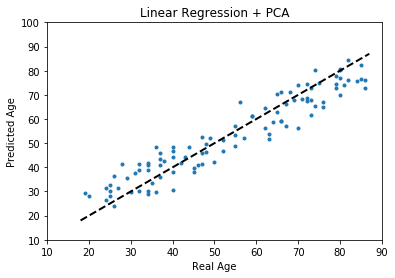

In [369]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_xlim(10,90)
ax.set_ylim(10,100)
ax.set_title("Linear Regression + PCA")
plt.savefig('pca.png')
plt.show()

##### XGBoost

In [44]:
# xgboost regressor
scores= {'MAE' : [], 'R2' : []}

for x, y, x_val, y_val in fold:
    eval_set = [(x_val, y_val)]
    xgbr = XGBRegressor(learning_rate=0.001, n_estimators=20000, max_depth=20, objective='reg:squarederror')
    xgbr.fit(x , y.ravel(), early_stopping_rounds=500, eval_metric="mae", eval_set=eval_set, verbose=False)
    y_pred =xgbr.predict(x_val)
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

=== RESULTS CROSS VAL ===
MAE cross validation : [7.727723571777344, 7.70224259185791]
R2 cross validation : [0.7204878323394392, 0.7414154347210768]

=== MEANS ===
MAE mean cross validation : 7.714983081817627
R2 mean cross validation : 0.730951633530258


In [45]:
print("\n\n--- TRAINING ON ALL DATASET ---\n\n")
xgbr = XGBRegressor(learning_rate=0.001, n_estimators=20000, max_depth=20, objective='reg:squarederror')
xgbr.fit(X_train_pca , y_train.ravel())

print("--- SCORES ON TEST SET ---\n")
y_pred = xgbr.predict(X_test_pca)
mae = mean_absolute_error(y_pred, y_test.ravel())
r2 = r2_score(y_test.ravel(), y_pred)

print(f"MAE test set : {mae}")
print(f"R2 test set : {r2}")



--- TRAINING ON ALL DATASET ---


--- SCORES ON TEST SET ---

MAE test set : 7.247689151763916
R2 test set : 0.7775686435477206


#### Regression with Neural Network


In [0]:
########################################
# ADD YOUR CODE HERE
########################################
import torch
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(inputSize, outputSize),
        )
        

    def forward(self, x):
        return self.main(x)

In [0]:
class LinDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, X, y):
        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(y)), desc='Loading Data')):
            tmp = torch.Tensor(X[idx,:])
            sample = {'features': tmp, 'y': torch.Tensor(y[idx])}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]
        return sample

In [0]:
num_epochs = 1000
learning_rate = 1e-5
batch_size = 64

modelLin_1 = linearRegression(inputSize=441, outputSize=1).to(device)
modelLin_1.train()
optimizer_1 = torch.optim.Adam(modelLin_1.parameters(), lr=learning_rate)

modelLin_2 = linearRegression(inputSize=441, outputSize=1).to(device)
modelLin_2.train()
optimizer_2 = torch.optim.Adam(modelLin_2.parameters(), lr=learning_rate)

In [139]:
ds1 = LinDataset(X_val_1, y_1)
ds2 = LinDataset(X_val_2, y_2)

dataloader_train_1 = torch.utils.data.DataLoader(ds1, batch_size=batch_size, shuffle=True)
dataloader_val_1 = torch.utils.data.DataLoader(ds2, batch_size=batch_size, shuffle=True)

dataloader_train_2 = torch.utils.data.DataLoader(ds2, batch_size=batch_size, shuffle=True)
dataloader_val_2 = torch.utils.data.DataLoader(ds1, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 250/250 [00:00<00:00, 33300.81it/s]


In [0]:
def train_lin(model, dataloader_t, dataloader_v, optimizer):
    loss_train_log = []
    loss_val_log = []
    epoch_val_log = []
    val_interval = 300
    print_every = 500
    best_val = 1000
    best_weights = 0


    print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):

        # Training
        for batch_idx, batch_samples in enumerate(dataloader_t):
            features, age = batch_samples['features'].to(device), batch_samples['y'].to(device)
            optimizer.zero_grad()
            prd = model(features)
            prd_flat = prd.view(-1)
            age_flat = age.view(-1)
            loss = nn.L1Loss()(prd_flat, age_flat)
            loss.backward()
            # print(loss.grad)
            optimizer.step()

        loss_train_log.append(loss.item())
        if epoch % print_every == 0:
            print(f"Epoch {epoch}")
        
        # Validation
        if dataloader_v is not None:
            if epoch == 1 or epoch % val_interval == 0:
                loss_val = 0
                mae_err = 0
                sum_pts = 0
                with torch.no_grad():
                    for data_sample in dataloader_v:
                        features, age = data_sample['features'].to(device), data_sample['y'].to(device)
                        prd = model(features)
                        prd_flat = prd.view(-1)
                        age_flat = age.view(-1)
                        loss_val += F.l1_loss(prd_flat, age_flat).item()
                        mae_err += mean_absolute_error(age_flat.cpu().numpy(), prd_flat.cpu().numpy())
                        sum_pts += 1

                loss_val /= sum_pts
                if loss_val < best_val:
                    best_weights = model.state_dict()

                loss_val_log.append(loss_val)
                epoch_val_log.append(epoch)

                print('--------------------------------------------------')
                print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
                print(f'+ MAE {mae_err/sum_pts}')
                print('--------------------------------------------------')
    if dataloader_v is not None:
        model.load_state_dict(best_weights)

    print('\nFinished TRAINING.')
    return model, loss_train_log, loss_val_log, epoch_val_log


In [141]:
model_lin1, loss_train_log_1, loss_val_log_1, epoch_val_log_1 = train_lin(modelLin_1, dataloader_train_1, dataloader_val_1, optimizer_1)

START TRAINING...
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 53.436092
+ MAE 53.4360933303833
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 300 	Loss: 53.730756
+ MAE 53.73075580596924
--------------------------------------------------
Epoch 500
--------------------------------------------------
+ VALIDATE 	Epoch: 600 	Loss: 54.024240
+ MAE 54.02424240112305
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 900 	Loss: 54.371929
+ MAE 54.371928215026855
--------------------------------------------------
Epoch 1000

Finished TRAINING.


In [143]:
modelLin_1(torch.Tensor(X_val_1[0,:]).to(device))

tensor([1.4025], device='cuda:0', grad_fn=<AddBackward0>)

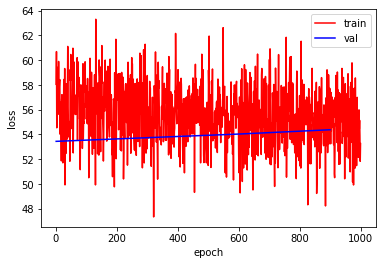

In [144]:
plt.plot(range(1, num_epochs + 1), loss_train_log_1, c='r', label='train')
plt.plot(epoch_val_log_1, loss_val_log_1, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
model_lin2, loss_train_log_2, loss_val_log_2, epoch_val_log_2 = train_lin(modelLin_2, dataloader_train_2, dataloader_val_2, optimizer_2)

START TRAINING...
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 53.616207
+ MAE 53.616207122802734
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 300 	Loss: 8.213947
+ MAE 8.213947296142578
--------------------------------------------------
Epoch 500
--------------------------------------------------
+ VALIDATE 	Epoch: 600 	Loss: 8.218754
+ MAE 8.218754291534424
--------------------------------------------------
--------------------------------------------------
+ VALIDATE 	Epoch: 900 	Loss: 8.244511
+ MAE 8.244511127471924
--------------------------------------------------
Epoch 1000

Finished TRAINING.


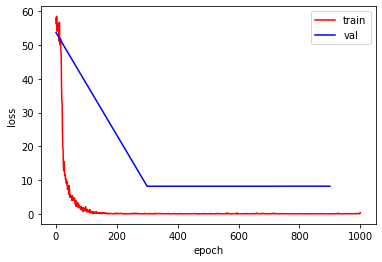

In [0]:
plt.plot(range(1, num_epochs + 1), loss_train_log_2, c='r', label='train')
plt.plot(epoch_val_log_2, loss_val_log_2, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
scores= {'MAE' : [], 'R2' : []}

# First Fold
with torch.no_grad():
    prd = modelLin_1(torch.Tensor(X_val_2).to(device))
    y_pred = prd.view(-1).cpu().numpy()
    y_val = y_2
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

# Second Fold
with torch.no_grad():
    prd = modelLin_2(torch.Tensor(X_val_1).to(device))
    y_pred = prd.view(-1).cpu().numpy()
    y_val = y_1
    scores['MAE'].append(mean_absolute_error(y_pred, y_val.ravel()))
    scores['R2'].append(r2_score(y_val.ravel(), y_pred))

print("=== RESULTS CROSS VAL ===")
print(f"MAE cross validation : {scores['MAE']}")
print(f"R2 cross validation : {scores['R2']}")

print("\n=== MEANS ===")
print(f"MAE mean cross validation : {np.array(scores['MAE']).mean()}")
print(f"R2 mean cross validation : {np.array(scores['R2']).mean()}")

=== RESULTS CROSS VAL ===
MAE cross validation : [7.798247116088867, 8.2511976852417]
R2 cross validation : [0.7260709341588204, 0.714521620619357]

=== MEANS ===
MAE mean cross validation : 8.024722400665283
R2 mean cross validation : 0.7202962773890886


In [0]:
# Training on all dataset
modelLin = linearRegression(inputSize=441, outputSize=1).to(device)
modelLin.train()
optimizer = torch.optim.Adam(modelLin.parameters(), lr=learning_rate)
ds = LinDataset(X_train_pca, y_train.reshape(-1,1), transform=False)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

model_lin, loss_train_log, loss_val_log, epoch_val_log = train_lin(modelLin, dataloader_train, None, optimizer)

Loading Data: 100%|██████████| 500/500 [00:00<00:00, 48102.02it/s]


START TRAINING...

Finished TRAINING.


In [0]:
with torch.no_grad():
    prd = model_lin(torch.Tensor(X_test_pca).to(device))
    y_pred = prd.view(-1).cpu().numpy()
    y_val = y_test

    mae = mean_absolute_error(y_pred, y_test.ravel())
    r2 = r2_score(y_test.ravel(), y_pred)

    print(f"MAE test set : {mae}")
    print(f"R2 test set : {r2}")


MAE test set : 25.659773111343384
R2 test set : -0.9211458912532882


## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

In [0]:
########################################
# ADD YOUR CODE HERE
########################################

Error calculation and plotting

In [0]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()